In [1]:
import os
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt

# Set working directory
os.chdir(r"..") # should be the git repo root directory
cwd = os.getcwd()
print("Current working directory: " + cwd)
assert os.getcwd()[-8:] == "WattCast", "Current working directory is not the git repo root directory"


Current working directory: d:\GitHub\WattCast


In [151]:
# Replace 'your_file_path.csv' with the actual path to your CSV file
df = pd.read_csv(os.path.join(cwd, 'data', 'raw_data', 'Portland_load_profile.csv'))

start_date = '2021-01-01 00:00:00'
end_date = pd.to_datetime(start_date) + pd.DateOffset(hours=8759)
datetime_series = pd.date_range(start=start_date, end=end_date, freq='H')
df['datetime'] = datetime_series


In [13]:
# Assuming your CSV file has two columns: 'timestamp' and 'value'
# Adjust the column names accordingly to match your dataset
time_series = TimeSeries.from_dataframe(df, 'datetime', 'Electric_MW')


In [14]:
print(f"==>> time_series.width: {time_series.width}")
time_series = time_series.add_datetime_attribute(attribute='weekday', cyclic=True).add_datetime_attribute(attribute='day', cyclic=True).add_datetime_attribute(attribute='month', cyclic=True)
print(f"==>> time_series.width: {time_series.width}")

==>> time_series.width: 1
==>> time_series.width: 7


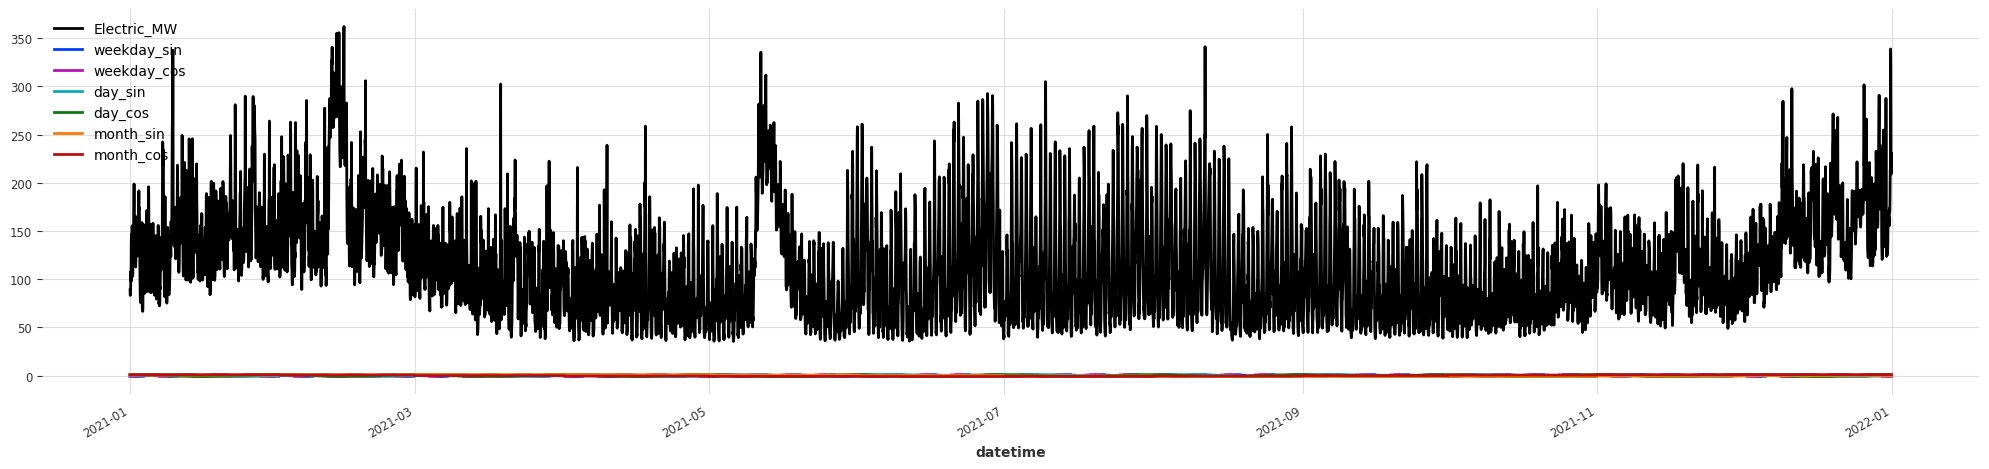

In [19]:
# Create a figure with a size of 15x5
plt.figure(figsize=(25, 5))

# Plot the TimeSeries
time_series.plot()

# Display the plot
plt.show()


In [23]:
time_series.components

Index(['Electric_MW', 'weekday_sin', 'weekday_cos', 'day_sin', 'day_cos',
       'month_sin', 'month_cos'],
      dtype='object', name='component')

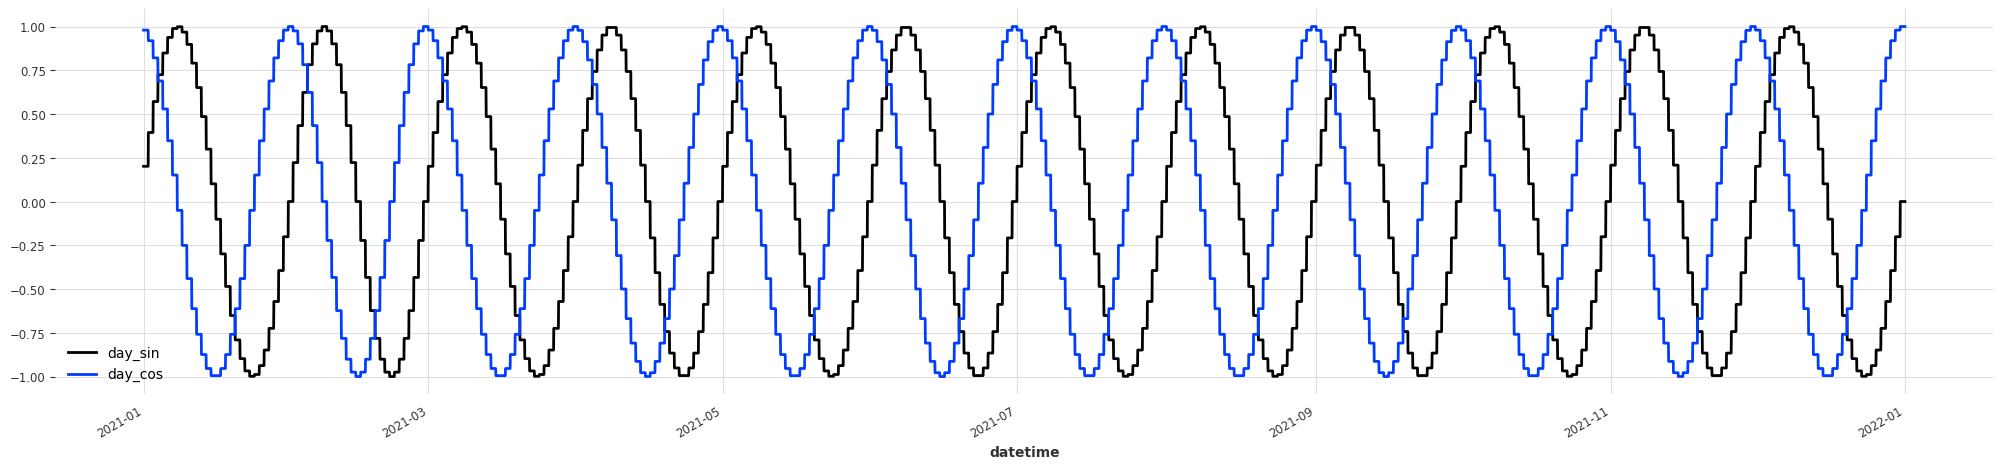

In [31]:
# Create a figure with a size of 15x5
plt.figure(figsize=(25, 5))

# Plot the TimeSeries
time_series[['day_sin', 'day_cos']].plot()

# Display the plot
plt.show()



In [61]:
# time_series.add_holidays(country_code='US', prov='CA')['holidays']

print(f"==>> time_series.start_time(): {time_series.start_time()}")
print(f"==>> time_series.end_time(): {time_series.end_time()}")

time_series.gaps()

==>> time_series.start_time(): 2021-01-01 00:00:00
==>> time_series.end_time(): 2021-12-31 23:00:00


,gap_start,gap_end


In [152]:
df


,Date/Time,Electric_MW,datetime
0,01/01 01:00:00,88.771360,2021-01-01 00:00:00
1,01/01 02:00:00,83.158460,2021-01-01 01:00:00
2,01/01 03:00:00,85.158351,2021-01-01 02:00:00
3,01/01 04:00:00,90.419156,2021-01-01 03:00:00
4,01/01 05:00:00,107.953171,2021-01-01 04:00:00
...,...,...,...
8755,12/31 20:00:00,338.846711,2021-12-31 19:00:00
8756,12/31 21:00:00,320.471721,2021-12-31 20:00:00
8757,12/31 22:00:00,232.384657,2021-12-31 21:00:00
8758,12/31 23:00:00,209.129105,2021-12-31 22:00:00


In [ ]:
# Develop a custom pytorch dataset class for time series data
# The following are high-level principles:
# 1. The dataset class should inherit from torch.utils.data.Dataset
# 2. The class 



In [153]:
df_t = df[['datetime', 'Electric_MW']].copy(deep=True)

df_t

,datetime,Electric_MW
0,2021-01-01 00:00:00,88.771360
1,2021-01-01 01:00:00,83.158460
2,2021-01-01 02:00:00,85.158351
3,2021-01-01 03:00:00,90.419156
4,2021-01-01 04:00:00,107.953171
...,...,...
8755,2021-12-31 19:00:00,338.846711
8756,2021-12-31 20:00:00,320.471721
8757,2021-12-31 21:00:00,232.384657
8758,2021-12-31 22:00:00,209.129105


In [170]:
import torch
from torch.utils.data import Dataset, DataLoader
from darts import TimeSeries
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data, history_length=24, forecast_length=3):
        self.data = data
        self.history_length = history_length
        self.forecast_length = forecast_length

    def __getitem__(self, index):
        # Get the historical data and target values for the current index
        history = self.data[index:index+self.history_length].values()
        target = self.data[index+self.history_length:index+self.history_length+self.forecast_length].values()

        return history, target

    def __len__(self):
        return len(self.data) - self.history_length - self.forecast_length + 1


# Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
series = TimeSeries.from_dataframe(df_t, 'datetime', 'Electric_MW')

# Define the seasonal chunks
num_chunks = 4
chunk_length = len(series) // num_chunks

# Define the split percentages for each chunk
split_pcts = [0.7, 0.2, 0.1]

# Initialize lists to store the split datasets
train_chunks = []
val_chunks = []
test_chunks = []

# Split the dataset into chunks and apply split percentages
for i in range(num_chunks):
    start_index = i * chunk_length
    end_index = (i + 1) * chunk_length

    chunk = series[start_index:end_index]

    split_sizes = np.array(split_pcts) * len(chunk)
    train_chunk = chunk[:int(split_sizes[0])]
    val_chunk = chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
    test_chunk = chunk[int(split_sizes[0] + split_sizes[1]):]

    train_chunks.append(train_chunk)
    val_chunks.append(val_chunk)
    test_chunks.append(test_chunk)

# Concatenate the chunks back together
train_series = train_chunks[0]
val_series = val_chunks[0]
test_series = test_chunks[0]

# for i in range(1, num_chunks):
#     train_series += train_chunks[i]
#     val_series += val_chunks[i]
#     test_series += test_chunks[i]

train_dataset = TimeSeriesDataset(train_series)
val_dataset = TimeSeriesDataset(val_series)
test_dataset = TimeSeriesDataset(test_series)

# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


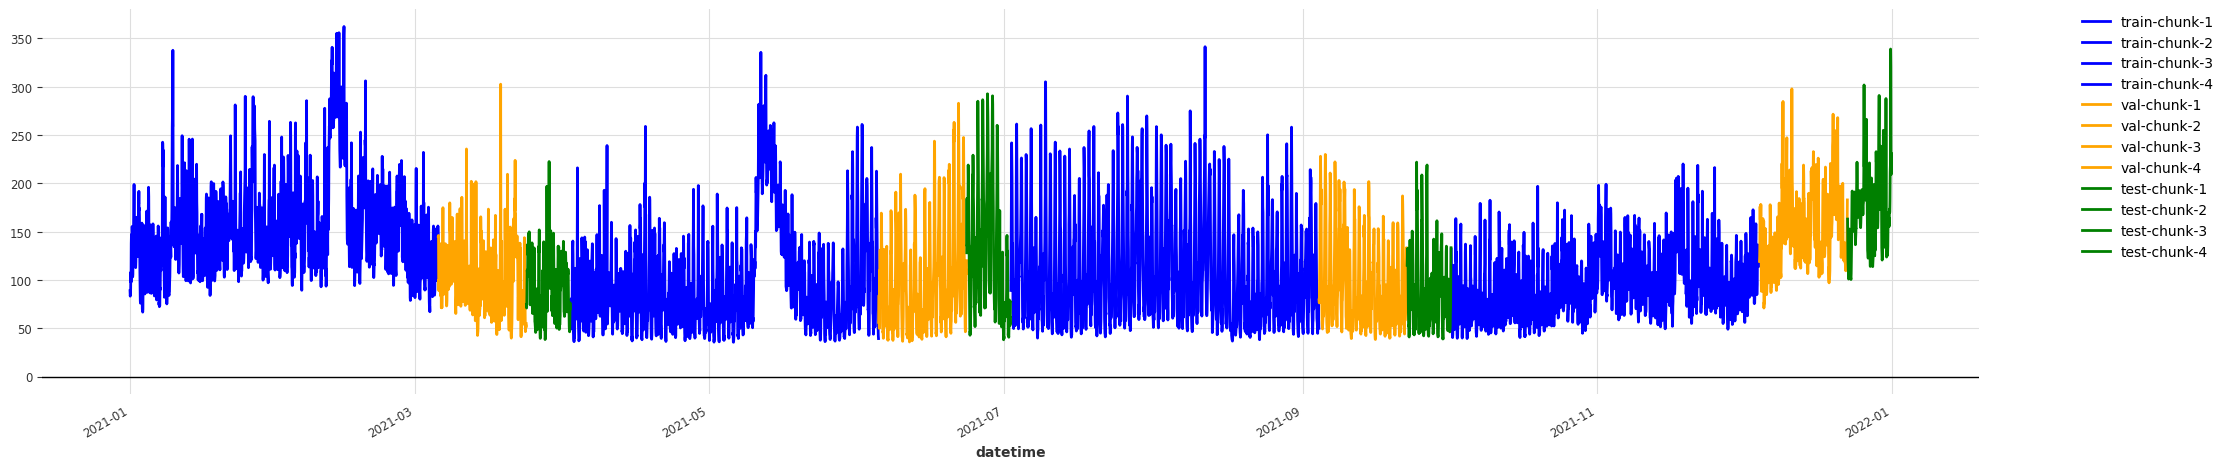

In [171]:
plt.figure(figsize=(25, 5))
train_chunks[0].plot(color='blue', label='train-chunk-1')
train_chunks[1].plot(color='blue', label='train-chunk-2')
train_chunks[2].plot(color='blue', label='train-chunk-3')
train_chunks[3].plot(color='blue', label='train-chunk-4')
val_chunks[0].plot(color='orange', label='val-chunk-1')
val_chunks[1].plot(color='orange', label='val-chunk-2')
val_chunks[2].plot(color='orange', label='val-chunk-3')
val_chunks[3].plot(color='orange', label='val-chunk-4')
test_chunks[0].plot(color='green', label='test-chunk-1')
test_chunks[1].plot(color='green', label='test-chunk-2')
test_chunks[2].plot(color='green', label='test-chunk-3')
test_chunks[3].plot(color='green', label='test-chunk-4')
# Move legend to the right, outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show plot axes lines
plt.axhline(0, color='black', lw=1)

In [174]:
train_chunks[0]

<TimeSeries (DataArray) (datetime: 1533, component: 1, sample: 1)>
array([[[ 88.77136044]],

       [[ 83.15846002]],

       [[ 85.15835087]],

       ...,

       [[124.830041  ]],

       [[155.7720454 ]],

       [[139.4990476 ]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 2021-01-01 ... 2021-03-05T20:00:00
  * component  (component) object 'Electric_MW'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [175]:
import torch
from torch.utils.data import Dataset, DataLoader
from darts import TimeSeries
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data, history_length=24, forecast_length=3):
        self.data = data
        self.history_length = history_length
        self.forecast_length = forecast_length

    def __getitem__(self, index):
        # Get the historical data and target values for the current index
        history = self.data[index:index+self.history_length].values()
        target = self.data[index+self.history_length:index+self.history_length+self.forecast_length].values()

        return history, target

    def __len__(self):
        return len(self.data) - self.history_length - self.forecast_length + 1


# Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
series = TimeSeries.from_dataframe(df_t, 'datetime', 'Electric_MW')

# Define the seasonal chunks
num_chunks = 4
chunk_length = len(series) // num_chunks

# Define the split percentages for each chunk
split_pcts = [0.7, 0.2, 0.1]

# Initialize lists to store the split datasets
train_chunks = []
val_chunks = []
test_chunks = []

# Split the dataset into chunks and apply split percentages
for i in range(num_chunks):
    start_index = i * chunk_length
    end_index = (i + 1) * chunk_length

    chunk = series[start_index:end_index]

    split_sizes = np.array(split_pcts) * len(chunk)
    train_chunk = chunk[:int(split_sizes[0])]
    val_chunk = chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
    test_chunk = chunk[int(split_sizes[0] + split_sizes[1]):]

    train_chunks.append(train_chunk)
    val_chunks.append(val_chunk)
    test_chunks.append(test_chunk)

# Concatenate the chunks back together
train_series = TimeSeries.concat(train_chunks)
val_series = TimeSeries.concat(val_chunks)
test_series = TimeSeries.concat(test_chunks)

train_dataset = TimeSeriesDataset(train_series)
val_dataset = TimeSeriesDataset(val_series)
test_dataset = TimeSeriesDataset(test_series)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


AttributeError: type object 'TimeSeries' has no attribute 'concat'

In [184]:
ts1, ts2, ts3, ts4 = train_chunks


# ts1

In [193]:
import torch
from torch.utils.data import Dataset, DataLoader
from darts import TimeSeries
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data_list, history_length=24, forecast_length=3):
        self.data_list = data_list
        self.history_length = history_length
        self.forecast_length = forecast_length
        self.lengths = [len(data) - history_length - forecast_length + 1 for data in self.data_list]

    def __getitem__(self, index):
        # Find the corresponding time series chunk and index within the chunk
        cum_lengths = np.cumsum(self.lengths)
        chunk_index = np.searchsorted(cum_lengths, index + 1)
        if chunk_index == 0:
            data_index = index
        else:
            data_index = index - cum_lengths[chunk_index - 1]

        # Get the historical data and target values for the current index
        history = self.data_list[chunk_index][data_index:data_index+self.history_length].values().copy()
        target = self.data_list[chunk_index][data_index+self.history_length:data_index+self.history_length+self.forecast_length].values().copy()

        return history, target

    def __len__(self):
        return sum(self.lengths)


# Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
series = TimeSeries.from_dataframe(df, 'datetime', 'Electric_MW')

# Define the seasonal chunks
num_chunks = 4
chunk_length = len(series) // num_chunks

# Define the split percentages for each chunk
split_pcts = [0.7, 0.2, 0.1]

# Initialize lists to store the split datasets
train_chunks = []
val_chunks = []
test_chunks = []

# Split the dataset into chunks and apply split percentages
for i in range(num_chunks):
    start_index = i * chunk_length
    end_index = (i + 1) * chunk_length

    chunk = series[start_index:end_index]

    split_sizes = np.array(split_pcts) * len(chunk)
    train_chunk = chunk[:int(split_sizes[0])]
    val_chunk = chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
    test_chunk = chunk[int(split_sizes[0] + split_sizes[1]):]

    train_chunks.append(train_chunk)
    val_chunks.append(val_chunk)
    test_chunks.append(test_chunk)

# Concatenate the chunks back together
train_dataset = TimeSeriesDataset(train_chunks)
val_dataset = TimeSeriesDataset(val_chunks)
test_dataset = TimeSeriesDataset(test_chunks)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    break


IndexError: The type of your index was not matched.


IndexError: The type of your index was not matched.

In [201]:
print(len(train_loader))

189
